In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [2]:
data = pd.read_csv('ecg_autoencoder_dataset.csv',header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


In [6]:
feature = data.drop(140,axis=1)
target = data[140]
X_train,X_test,Y_train,Y_test = train_test_split(feature,target,test_size=0.2,stratify=target)
train_index = Y_train[Y_train==1].index
train_data = X_train.loc[train_index]

In [9]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_train_scaled = min_max_scaler.fit_transform(train_data)
x_test_scaled = min_max_scaler.transform(X_test)

In [29]:
class AutoEncoder(tf.keras.Model):
    def __init__(self,output_units,ldim=8):
        super().__init__()
        self.encoder = Sequential([
            Dense(16,activation='relu'),
            Dropout(0.1),
            Dense(32,activation='relu'),
            Dropout(0.1),
            Dense(64,activation='relu'),
            Dropout(0.1),
            Dense(ldim,activation='relu')
        ])
        self.decoder = Sequential([
            Dense(64,activation='relu'),
            Dropout(0.1),
            Dense(32,activation='relu'),
            Dropout(0.1),
            Dense(16,activation='relu'),
            Dropout(0.1),
            Dense(output_units,activation='sigmoid')
        ])
    
    def call(self,input) :
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded


In [33]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
model.compile(loss='msle',optimizer='adam',metrics=['mse'])
epochs = 20
h = model.fit(x_train_scaled,x_train_scaled,validation_data=(x_test_scaled,x_test_scaled),epochs=20,batch_size=512)

Epoch 1/20
5/5 [==============================] - 2s 71ms/step - loss: 0.0111 - mse: 0.0247 - val_loss: 0.0132 - val_mse: 0.0306
Epoch 2/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0109 - mse: 0.0243 - val_loss: 0.0131 - val_mse: 0.0303
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0107 - mse: 0.0239 - val_loss: 0.0129 - val_mse: 0.0299
Epoch 4/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0104 - mse: 0.0232 - val_loss: 0.0127 - val_mse: 0.0296
Epoch 5/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0100 - mse: 0.0224 - val_loss: 0.0126 - val_mse: 0.0293
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0096 - mse: 0.0214 - val_loss: 0.0124 - val_mse: 0.0288
Epoch 7/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0091 - mse: 0.0202 - val_loss: 0.0121 - val_mse: 0.0281
Epoch 8/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0085 - mse: 0.0189 - val

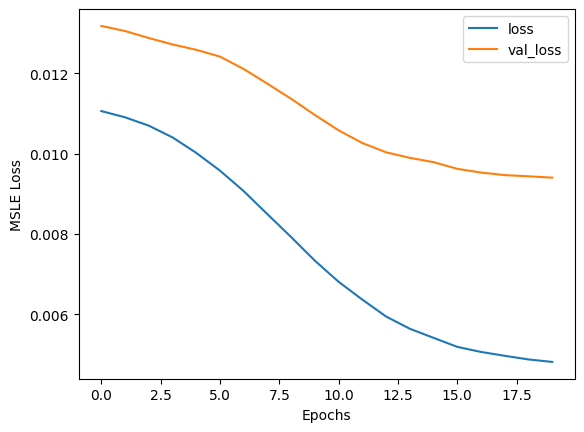

In [34]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [37]:
def find_threshold(model,x_train_scaled):
    rec = model.predict(x_train_scaled)
    rec_error = tf.keras.losses.msle(rec,x_train_scaled)
    threshold = np.mean(rec_error.numpy()) + np.std(rec_error.numpy())
    return threshold

def get_predictions(model,x_test_scaled,threshold):
    predictions = model.predict(x_test_scaled)
    pred_error = tf.keras.losses.msle(predictions,x_test_scaled)
    anomaly_mask = pd.Series(pred_error) > threshold
    pred = anomaly_mask.map(lambda x:0.0 if x==True else 1.0)
    return pred


threshold = find_threshold(model,x_train_scaled)
print(threshold)

73/73 [==============================] - 0s 2ms/step
0.0099774188164511


In [39]:
res = get_predictions(model,x_test_scaled,threshold)
accuracy_score(res,Y_test)

32/32 [==============================] - 0s 2ms/step


0.95